In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.transform import *
from skimage.color import *


In [3]:
FILE_PATH = '/kaggle/input/petfinder-pawpularity-score/train'

count = 0
mappings = dict()
images = []
# parse through all files in the directory
for dirpath, dirs, files in os.walk(FILE_PATH): 
    for filename in files:
        if count == 250:
            break
        img_path = dirpath+'/'+filename
        # read images
        img = cv2.imread(img_path)
        img = resize(img, (32, 32))
        mappings[filename.split('.')[0]] = img
        images.append(img)
        count += 1
  

In [4]:
np.array(images).max()

1.0

In [5]:
images_df = pd.DataFrame(mappings.items(), columns = ['Id','image'])
images_df.head()

,Id,image
0,7954ebb5c90d9618e34959df0ad5f062,"[[[0.8085110995462915, 0.8128895632570354, 0.8..."
1,2969162fab1d0e5a65e4ce02db267745,"[[[0.1428951739514301, 0.1937137382307242, 0.2..."
2,9f32ae94d7723414cb8fa881a1c6626c,"[[[0.060462790072490086, 0.0627508977950898, 0..."
3,b8f920f44800ee71e4659dea84bc9bef,"[[[0.6358429081863435, 0.6643227203623732, 0.6..."
4,7fc71b8da143721939715b1cfe22122f,"[[[0.08754420143711472, 0.30043968625610373, 0..."


In [6]:
train_table = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/train.csv')

In [7]:
train_table.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [8]:
paw_merge = images_df.merge(train_table, on = 'Id')

In [9]:
image_score_df = paw_merge[['image', 'Pawpularity']]
image_score_df.head()

,image,Pawpularity
0,"[[[0.8085110995462915, 0.8128895632570354, 0.8...",38
1,"[[[0.1428951739514301, 0.1937137382307242, 0.2...",29
2,"[[[0.060462790072490086, 0.0627508977950898, 0...",26
3,"[[[0.6358429081863435, 0.6643227203623732, 0.6...",27
4,"[[[0.08754420143711472, 0.30043968625610373, 0...",19


In [10]:
train_df = image_score_df.iloc[0:200, :]
valid_df = image_score_df.iloc[200:225, :]
test_df = image_score_df.iloc[225:250, :]

In [11]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(200, 2)
(25, 2)
(25, 2)


In [12]:
x_train = np.array(np.array(images[0:200]) * 255, dtype = np.uint8)
y_train = train_df['Pawpularity'].to_numpy()

In [13]:
x_val = np.array(np.array(images[200:225]) * 255, dtype = np.uint8)
y_val = valid_df['Pawpularity'].to_numpy()

In [14]:
x_test = np.array(np.array(images[225:250]) * 255, dtype = np.uint8)
y_test = test_df['Pawpularity'].to_numpy()

In [15]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(200, 32, 32, 3)
(200,)
(25, 32, 32, 3)
(25,)
(25, 32, 32, 3)
(25,)


In [16]:
!pip install -U tensorflow-addons

/bin/bash: pip install -U tensorflow-addons: command not found


In [17]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers
from keras.layers import Reshape
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomContrast

# Set seed for reproducibiltiy
SEED = 42
tf.random.set_seed(SEED)
tf.compat.v1.enable_eager_execution()

In [18]:
# DATA
BATCH_SIZE = 10
BUFFER_SIZE = BATCH_SIZE * 2
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 1  # for attention mapping related to continuous regression decision

# AUGMENTATION
IMAGE_SIZE = 32  # We will resize input images to this size.

# ARCHITECTURE
DIMENSIONS = 3072
SE_RATIO = 8
TRUNK_DEPTH = 2

# OPTIMIZER
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 500

In [19]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

Training samples: 200
Validation samples: 25
Testing samples: 25


2022-11-30 05:29:48.731654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 05:29:48.732611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 05:29:48.912033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 05:29:48.912918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 05:29:48.913695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [20]:
train_ds

<PrefetchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.uint8, tf.int64)>

In [21]:
def get_preprocessing():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0), layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="preprocessing",
    )
    return model


def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model

In [22]:

def build_convolutional_stem(dimensions):
    """Build the convolutional stem.

    Args:
        dimensions: The embedding dimension of the patches (d in paper).

    Returs:
        The convolutional stem as a keras seqeuntial
        model.
    """
    config = {
        "kernel_size": (3, 3),
        "strides": (2, 2),
        "activation": tf.nn.gelu,
        "padding": "same",
    }

    convolutional_stem = keras.Sequential(
        [
            layers.Conv2D(filters=dimensions // 2, **config),
            layers.Conv2D(filters=dimensions, **config),
        ],
        name="convolutional_stem",
    )

    return convolutional_stem


In [23]:

class SqueezeExcite(layers.Layer):
    """Applies squeeze and excitation to input feature maps as seen in
    https://arxiv.org/abs/1709.01507.

    Args:
        ratio: The ratio with which the feature map needs to be reduced in
        the reduction phase.

    Inputs:
        Convolutional features.

    Outputs:
        Attention modified feature maps.
    """

    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio

    def get_config(self):
        config = super().get_config()
        config.update({"ratio": self.ratio})
        return config

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(
            units=filters // self.ratio, activation="relu", use_bias=False,
        )
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()

    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x


class Trunk(layers.Layer):
    """Convolutional residual trunk as in the https://arxiv.org/abs/2112.13692

    Args:
        depth: Number of trunk residual blocks
        dimensions: Dimnesion of the model (denoted by d in the paper)
        ratio: The Squeeze-Excitation ratio

    Inputs:
        Convolutional features extracted from the conv stem.

    Outputs:
        Flattened patches.
    """

    def __init__(self, depth, dimensions, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio
        self.dimensions = dimensions
        self.depth = depth

    def get_config(self):
        config = super().get_config()
        config.update(
            {"ratio": self.ratio, "dimensions": self.dimensions, "depth": self.depth,}
        )
        return config

    def build(self, input_shape):
        config = {
            "filters": self.dimensions,
            "activation": tf.nn.gelu,
            "padding": "same",
        }

        trunk_block = [
            layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(kernel_size=(1, 1), **config),
            layers.Conv2D(kernel_size=(3, 3), **config),
            SqueezeExcite(ratio=self.ratio),
            layers.Conv2D(kernel_size=(1, 1), filters=self.dimensions, padding="same"),
        ]

        self.trunk_blocks = [keras.Sequential(trunk_block) for _ in range(self.depth)]
        self.add = layers.Add()
        self.flatten_spatial = layers.Reshape((-1, self.dimensions))

    def call(self, x):
        # Remember the input.
        shortcut = x
        for trunk_block in self.trunk_blocks:
            output = trunk_block(x)
            shortcut = self.add([output, shortcut])
            x = shortcut
        # Flatten the patches.
        x = self.flatten_spatial(x)
        print("truck dimen {}".format(x))
        return x


In [30]:
# Taking a batch of test inputs to measure model's progress.
test_images, test_labels = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 4:
            test_augmented_images = self.model.preprocessing_model(test_images)
            # Pass through the stem.
            test_x = self.model.stem(test_augmented_images)
            # Pass through the trunk.
            test_x = self.model.trunk(test_x)
            # Pass through the attention pooling block.
            _, test_viz_weights = self.model.attention_pooling(test_x)
            # Reshape the vizualization weights
            num_patches = tf.shape(test_viz_weights)[-1]
            #print(num_patches)
            height = width = int(math.sqrt(num_patches))
            test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
            # Take a random image and its attention weights.
            index = np.random.randint(low=0, high=tf.shape(test_augmented_images)[0])
            selected_image = test_augmented_images[index]
            selected_weight = test_viz_weights[index]
            #print(sum(selected_weight))
            # Plot the images and the overlayed attention map.
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
            ax[0].imshow(selected_image)
            ax[0].set_title(f"Original: {epoch:03d}")
            ax[0].axis("off")
            img = ax[1].imshow(selected_image)
            ax[1].imshow(
                selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent()
            )
            ax[1].set_title(f"Attended: {epoch:03d}")
            ax[1].axis("off")
            plt.axis("off")
            plt.show()
            plt.close()


In [31]:

class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

In [32]:

class AttentionPooling(layers.Layer):
    """Applies attention to the patches extracted form the
    trunk with the CLS token.

    Args:
        dimensions: The dimension of the whole architecture.
        num_classes: The number of classes in the dataset.

    Inputs:
        Flattened patches from the trunk.

    Outputs:
        The modified CLS token.
    """

    def __init__(self, dimensions, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.dimensions = dimensions
        self.num_classes = num_classes
        self.cls = tf.Variable(tf.zeros((1, 1, dimensions)))

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "dimensions": self.dimensions,
                "num_classes": self.num_classes,
                "cls": self.cls.numpy(),
            }
        )
        return config

    def build(self, input_shape):
        self.attention = layers.MultiHeadAttention(
            num_heads=1, key_dim=self.dimensions, dropout=0.2,
        )
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = keras.Sequential(
            [
                layers.Dense(units=self.dimensions, activation=tf.nn.gelu),
                layers.Dropout(0.2),
                layers.Dense(units=self.dimensions, activation=tf.nn.gelu),
            ]
        )
        
        #Final layer of attention map
        self.dense = layers.Dense(units=1,activation='linear')
        self.flatten = layers.Flatten()
        
        self.global2d = layers.GlobalAveragePooling2D()
        self.reshape = layers.Reshape(target_shape=(32,32,3))
        self.resnet = ResNet50(include_top=False, weights= 'imagenet', pooling=None, input_shape = (32, 32 , 3))
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        #print("Shape of one patch: {}" .format(tf.shape(x)))
        # Expand the class token batch number of times.
        class_token = tf.repeat(self.cls, repeats=batch_size, axis=0)
        # Concat the input with the trainable class token.
        x = tf.concat([class_token, x], axis=1)
        # Apply attention to x.
        x = self.layer_norm1(x)
        x, viz_weights = self.attention(
            query=x[:, 0:1], key=x, value=x, return_attention_scores=True
        )
        
        #print(viz_weights)
        #print(x)
        
        class_token = class_token + x
        
        #print(class_token)
        
        class_token = self.layer_norm2(class_token)
        class_token = self.flatten(class_token)
        class_token = self.layer_norm3(class_token)
        class_token = class_token + self.mlp(class_token)
        
        class_token = self.reshape(class_token)
        
        #256 1D
        #print(class_token)
        
        #print(image_inputs)
        
        image_x = self.resnet(class_token)
        #print(image_x)
        
        image_x = self.global2d(image_x)
        
        #print(image_x)
        # Build the logits
        logits = self.dense(image_x)
        #print(logits)
        
        return logits, tf.squeeze(viz_weights)[..., 1:]


In [33]:

class PatchConvNet(keras.Model):
    def __init__(
        self,
        stem,
        trunk,
        attention_pooling,
        preprocessing_model,
        train_augmentation_model,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.stem = stem
        self.trunk = trunk
        self.attention_pooling = attention_pooling
        self.train_augmentation_model = train_augmentation_model
        self.preprocessing_model = preprocessing_model

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "stem": self.stem,
                "trunk": self.trunk,
                "attention_pooling": self.attention_pooling,
                "train_augmentation_model": self.train_augmentation_model,
                "preprocessing_model": self.preprocessing_model,
            }
        )
        return config

    def _calculate_loss(self, inputs, test=False):
        images, labels = inputs
        # Augment the input images.
        if test:
            augmented_images = self.preprocessing_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        #print('self trunk'.format(x))
        logits, _ = self.attention_pooling(x)
        # Compute the total loss.
        #print(logits)
        total_loss = self.compiled_loss(labels, logits)
        #print(total_loss)
        return total_loss, logits

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            total_loss, logits = self._calculate_loss(inputs)
        # Apply gradients.
        train_vars = [
            self.stem.trainable_variables,
            self.trunk.trainable_variables,
            self.attention_pooling.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        trainable_variable_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                trainable_variable_list.append((g, v))
        self.optimizer.apply_gradients(trainable_variable_list)
        # Report progress.
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        total_loss, logits = self._calculate_loss(inputs, test=True)
        # Report progress.
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def call(self, images):
        # Augment the input images.
        augmented_images = self.preprocessing_model(images)
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        logits, viz_weights = self.attention_pooling(x)
        return logits, viz_weights


In [ ]:
train_augmentation_model = get_train_augmentation_model()
preprocessing_model = get_preprocessing()
conv_stem = build_convolutional_stem(dimensions=DIMENSIONS)
conv_trunk = Trunk(depth=TRUNK_DEPTH, dimensions=DIMENSIONS, ratio=SE_RATIO)
attention_pooling = AttentionPooling(dimensions=DIMENSIONS, num_classes=NUM_CLASSES)

patch_conv_net = PatchConvNet(
    stem=conv_stem,
    trunk=conv_trunk,
    attention_pooling=attention_pooling,
    train_augmentation_model=train_augmentation_model,
    preprocessing_model=preprocessing_model,
)

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]
# Get the optimizer.
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
# Compile and pretrain the model.
patch_conv_net.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
    metrics=[
        keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None
),
    ],
)
history = patch_conv_net.fit(
    train_ds, epochs=EPOCHS,
     validation_data=val_ds,
      callbacks=train_callbacks,
)

# Evaluate the model with the test dataset.
loss, rmse = patch_conv_net.evaluate(test_ds)
print(f"Loss: {loss:0.2f}")
print(f"RMSE: {rmse:0.2f}")

Attention maps

truck dimen [[[-0.21346168  0.0702888   0.11949164 ...  0.137703   -0.02793177
   -0.02564799]
  [-0.1412999   0.18183282 -0.15954071 ...  0.0417731  -0.08258563
   -0.15251026]
  [-0.18583393  0.35098535 -0.35342532 ... -0.16652568 -0.04940495
   -0.1645639 ]
  ...
  [-0.1895305   0.09126476 -0.09443606 ...  0.05756614  0.07471318
   -0.17443801]
  [-0.26490933  0.08607281 -0.14232472 ...  0.01172609  0.17047475
   -0.11429042]
  [ 0.00612728 -0.08253981  0.05925277 ...  0.0221121   0.01582574
   -0.01816319]]]
viz_weights first (144,)
viz_weights (1, 144)
viz_weights reshaped (1, 12, 12)
(1, 12, 12)
selected image shape (48, 48, 3)
selected weight (12, 12)


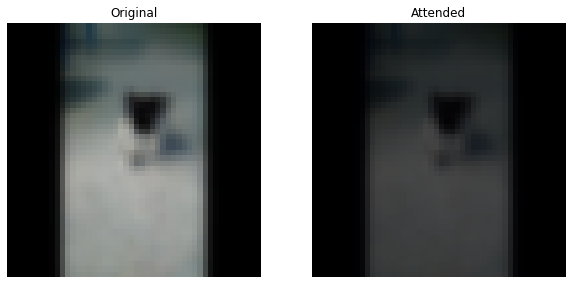

In [38]:

def plot_attention(image):
    """Plots the attention map on top of the image.

    Args:
        image: A numpy image of arbitrary size.
    """
    # Resize the image to a (32, 32) dim.
    #image = tf.image.resize(image, (32, 32))
    image = image[tf.newaxis, ...]
    test_augmented_images = patch_conv_net.preprocessing_model(image)
    #print(test_augmented_images.shape)
    # Pass through the stem.
    test_x = patch_conv_net.stem(test_augmented_images)
    #print(test_x.shape)
    # Pass through the trunk.
    test_x = patch_conv_net.trunk(test_x)
    #print(test_x.shape)
    # Pass through the attention pooling block.
    _, test_viz_weights = patch_conv_net.attention_pooling(test_x)
    print("viz_weights first", test_viz_weights.shape)
    test_viz_weights = test_viz_weights[tf.newaxis, ...]
    print("viz_weights", test_viz_weights.shape)
    # Reshape the vizualization weights.
    num_patches = tf.shape(test_viz_weights)[-1]
    #print(num_patches)
    height = width = int(math.sqrt(num_patches))
    test_viz_weights = layers.Reshape((height, width))(test_viz_weights)
    print("viz_weights reshaped", test_viz_weights.shape)
    print(test_viz_weights.shape)
    selected_image = test_augmented_images[0]
    print("selected image shape",selected_image.shape)
    selected_weight = test_viz_weights[0]
    print("selected weight",selected_weight.shape)
    #print(selected_weight.shape)
    # Plot the images.
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(selected_image)
    ax[0].set_title(f"Original")
    ax[0].axis("off")
    img = ax[1].imshow(selected_image)
    ax[1].imshow(selected_weight, cmap="inferno", alpha=0.6, extent=img.get_extent())
    ax[1].set_title(f"Attended")
    ax[1].axis("off")
    plt.axis("off")
    plt.show()
    plt.close()


# url = "http://farm9.staticflickr.com/8017/7140384795_385b1f48df_z.jpg"
# image_name = keras.utils.get_file(fname="image.jpg", origin=url)
# image = tf.io.read_file(image_name)
# image = tf.io.decode_image(image)
#plot_attention(np.array(aval_x_test[0], dtype = np.uint8))
#plot_attention(np.array(aval_x_test[0], dtype = np.uint8))

plot_attention(x_test[0])

In [ ]:
### One sample example is shown here